In [17]:
%reload_ext autoreload
%autoreload 2

from helpers import *
from spice_net import *

import numpy as np
import networkx as nx
import tqdm
import random
import json
import matplotlib.pyplot as plt

import PySpice
PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = "ngspice-shared" 
import PySpice.Spice.NgSpice.Server
PySpice.Spice.NgSpice.Server.SpiceServer.SPICE_COMMAND = 'ngspice'

In [18]:
import PySpice.Spice.NgSpice.Shared

instance = PySpice.Spice.NgSpice.Shared.NgSpiceShared.new_instance()

In [68]:
R_LEARN = u_Ohm(1000)
C_LEARN = u_uF(22)

In [69]:
VIN = u_V(1)
VCLAMP = u_V(0.2)

In [70]:
# handmake a twin edge voltage divider
cir = Circuit('twin_edge_divider')

cir.subcircuit(Teacher(c_learn=C_LEARN))
cir.subcircuit(TransistorEdgeTeacher())
cir.model('nmos', 'nmos', level=1)
cir.model('Ideal', 'nmos', level=1)
cir.model("MYSW", "SW", Ron=R_LEARN, Roff=1e12, Vt=0.5,)

cir.X("EC1", "transistor_edge_teacher", "C1", cir.gnd, "VGS1")
# cir.X("EC1", "transistor_edge", "C1", cir.gnd, vgs="{V(VGS1)}")
# cir.X("EC2", "transistor_edge", "C2", "C1", "{V(VGS2)}")
cir.X("EC2", "transistor_edge_teacher", "C2", "C1", "VGS2")
# cir.R(1, "C2", "C1", u_kOhm(10))
cir.X("EF1", "transistor_edge_teacher", "F1", cir.gnd, "VGS1")
# cir.X("EF1", "transistor_edge", "F1", cir.gnd, vgs="{V(VGS1)}")
# cir.X("EF2", "transistor_edge", "F2", "F1", "{V(VGS2)}")
cir.X("EF2", "transistor_edge_teacher", "F2", "F1", "VGS2")
# cir.R(2, "F2", "F1", u_kOhm(10))

cir.X("T1", "teacher", "F1", cir.gnd, "C1", cir.gnd, "VGS1", "CLK",)
cir.X("T2", "teacher", "F2", "F1", "C2", "C1", "VGS2", "CLK",)

# cir.PulseVoltageSource("VCLK", "CLK", cir.gnd, initial_value=0, pulsed_value=1, pulse_width=u_us(10), period=u_us(20))
cir.PulseVoltageSource("VCLK", "CLK", cir.gnd, initial_value=0, pulsed_value=1, pulse_width=u_ms(10), period=u_ms(20))

# constant inputs
cir.V("FI1", "F2", cir.gnd, VIN)
cir.V("CI1", "C2", cir.gnd, VIN)

# clamps
cir.V("CC1", "C1", cir.gnd, VCLAMP)

VoltageSource VCC1

In [71]:
simulator = cir.simulator(temperature=25, nominal_temperature=25)

In [72]:
simulator.initial_condition(VGS1=1, VGS2=1)

In [73]:
print(simulator)

.title twin_edge_divider
.subckt teacher D_FREE S_FREE D_CLAMPED S_CLAMPED VGS CLK
BUPDATE nudge 0 v=V(VGS)+((V(S_FREE)-V(D_FREE))**2-(V(S_CLAMPED)-V(D_CLAMPED))**2)
S1 nudge VGS CLK 0 MYSW on
C1 VGS 0 22uF
.ends teacher

.subckt transistor_edge_teacher t_D t_S VGS
B1 t_G t_S v=V(VGS)
R1 t_D t_S 1e+16
M1 t_D t_G t_S t_S Ideal
.ends transistor_edge_teacher
XEC1 C1 0 VGS1 transistor_edge_teacher
XEC2 C2 C1 VGS2 transistor_edge_teacher
XEF1 F1 0 VGS1 transistor_edge_teacher
XEF2 F2 F1 VGS2 transistor_edge_teacher
XT1 F1 0 C1 0 VGS1 CLK teacher
XT2 F2 F1 C2 C1 VGS2 CLK teacher
VVCLK CLK 0 DC 0V PULSE(0V 1V 0s 0s 0s 10ms 20ms)
VFI1 F2 0 1V
VCI1 C2 0 1V
VCC1 C1 0 0.2V
.model nmos nmos (level=1)
.model Ideal nmos (level=1)
.model MYSW SW (Roff=1000000000000.0 Ron=1000Ohm Vt=0.5)
.options TEMP = 25C
.options TNOM = 25C
.ic V(VGS1)=1 V(VGS2)=1
.end



In [78]:
res = simulator.transient(step_time=u_ms(1), end_time=0.5)

Using SPARSE 1.3 as Direct Linear Solver


In [79]:
print(res.simulation)

.title twin_edge_divider
.subckt teacher D_FREE S_FREE D_CLAMPED S_CLAMPED VGS CLK
BUPDATE nudge 0 v=V(VGS)+((V(S_FREE)-V(D_FREE))**2-(V(S_CLAMPED)-V(D_CLAMPED))**2)
S1 nudge VGS CLK 0 MYSW on
C1 VGS 0 22uF
.ends teacher

.subckt transistor_edge_teacher t_D t_S VGS
B1 t_G t_S v=V(VGS)
R1 t_D t_S 1e+16
M1 t_D t_G t_S t_S Ideal
.ends transistor_edge_teacher
XEC1 C1 0 VGS1 transistor_edge_teacher
XEC2 C2 C1 VGS2 transistor_edge_teacher
XEF1 F1 0 VGS1 transistor_edge_teacher
XEF2 F2 F1 VGS2 transistor_edge_teacher
XT1 F1 0 C1 0 VGS1 CLK teacher
XT2 F2 F1 C2 C1 VGS2 CLK teacher
VVCLK CLK 0 DC 0V PULSE(0V 1V 0s 0s 0s 10ms 20ms)
VFI1 F2 0 1V
VCI1 C2 0 1V
VCC1 C1 0 0.2V
.model nmos nmos (level=1)
.model Ideal nmos (level=1)
.model MYSW SW (Roff=1000000000000.0 Ron=1000Ohm Vt=0.5)
.options TEMP = 25C
.options TNOM = 25C
.ic V(VGS1)=1 V(VGS2)=1
.end



In [80]:
res.nodes.keys()

dict_keys(['xt2.nudge', 'clk', 'xt1.nudge', 'f2', 'xef2.t_g', 'f1', 'xef1.t_g', 'c2', 'vgs2', 'xec2.t_g', 'c1', 'vgs1', 'xec1.t_g'])

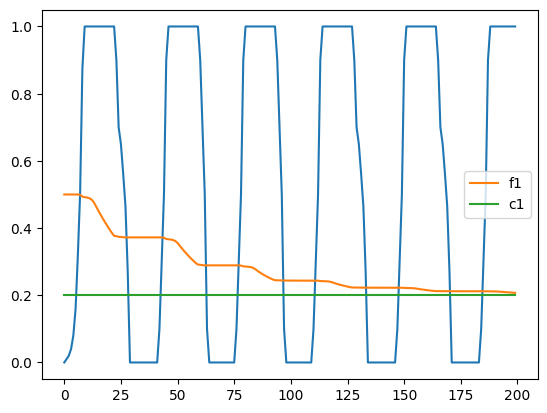

In [87]:
MAX_STEP = 200
plt.plot(res.nodes['clk'][:MAX_STEP])
plt.plot(res.nodes['f1'][:MAX_STEP], label='f1')
plt.plot(res.nodes['c1'][:MAX_STEP], label='c1')
# plt.plot(res.nodes['vgs1'][:MAX_STEP], label='vgs1')
# plt.plot(res.nodes['xt1.nudge'][:MAX_STEP], label='nudge')
# plt.plot(res.nodes['f1']**2 - res.nodes['c1']**2, label='CL')
# plt.plot(res.nodes['vgs2'][:MAX_STEP], label='vgs2')
plt.legend()

In [127]:
cir2 = Circuit("""hh
M1 GFREE N001 0 0 NMOS
M2 GCLAMP N002 0 0 NMOS
VCLOCK CLOCK 0 PULSE(0 1 0 1e-6 1e-6 {th} {2*th})
Vin N003 0 1
S1 VNUDGE VGS CLOCK 0 MYSW
C1 0 VGS {clearn}
BV1 VNUDGE 0 V=V(VGS)+((V(0)-V(GFREE))**2-(V(0)-V(GCLAMP))**2)
B1 N001 0 V=V(VGS)
B2 N002 0 V=V(VGS)
VCLAMP GCLAMP 0 .5
R4 GFREE N003 {R}
R3 GCLAMP N003 {R}
.model NMOS NMOS
.model PMOS PMOS
.model MYSW SW(Ron={rlearn} Roff=1e12 Vt=0.5)
* .tran 1ms 500ms
.ic  V(VGS)=1
.model NMOS NMOS
.param R=10k
.param th=18ms
.param clearn=22uf
.param rlearn=100
.end""")

In [128]:
print(cir2)

.title hh
M1 GFREE N001 0 0 NMOS
M2 GCLAMP N002 0 0 NMOS
VCLOCK CLOCK 0 PULSE(0 1 0 1e-6 1e-6 {th} {2*th})
Vin N003 0 1
S1 VNUDGE VGS CLOCK 0 MYSW
C1 0 VGS {clearn}
BV1 VNUDGE 0 V=V(VGS)+((V(0)-V(GFREE))**2-(V(0)-V(GCLAMP))**2)
B1 N001 0 V=V(VGS)
B2 N002 0 V=V(VGS)
VCLAMP GCLAMP 0 .5
R4 GFREE N003 {R}
R3 GCLAMP N003 {R}
.model NMOS NMOS
.model PMOS PMOS
.model MYSW SW(Ron={rlearn} Roff=1e12 Vt=0.5)
* .tran 1ms 500ms
.ic  V(VGS)=1
.model NMOS NMOS
.param R=10k
.param th=18ms
.param clearn=22uf
.param rlearn=100
.end




In [129]:
sim2 = cir2.simulator()

In [130]:
sim2.transient(step_time=u_ms(1), end_time=0.1)

run simulation not started


NameError: Simulation failed

In [120]:
MAX_STEP = 1000
plt.plot(res2.nodes['clk'][:MAX_STEP])
plt.plot(res2.nodes['f1'][:MAX_STEP], label='f1')
plt.plot(res2.nodes['c1'][:MAX_STEP], label='c1')
plt.plot(res2.nodes['vgs1'][:MAX_STEP], label='vgs1')
# plt.plot(res.nodes['vgs2'][:MAX_STEP], label='vgs2')
plt.legend()

AttributeError: 'NoneType' object has no attribute 'nodes'